# Fig2 mammals annotated structure matrix - draft figure

This code sets up the draft for fig1. Labels are then rearranged manually.


## 1. helper functions

In [1]:
from collections import defaultdict,Counter
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
def yieldStructureMatrix_bin( inHandle ):
	"""

	Takes:
		- inHandle : input binary handle

	Yield:
		str : sequence name
		numpy array : correlation of the sequence with some others 
					(corresponding to a line in the lower triangular matrix)
	"""

	i = 0
	name = inHandle.readline().decode('ascii').strip()
	while name:
		arr = np.fromfile( inHandle , dtype=np.float64 , count = i )
		yield name, arr
		i+=1
		name = inHandle.readline().decode('ascii').strip()

def readStructureMatrix_bin( pth ):
	"""

	Takes:
		- pth : str. name of the file to read

	Yield:
		list : list contnaing sequence names
		numpy array :  2D structure matrix

	"""

	seqList = []
	lines = []

	with open( pth , 'rb' ) as IN:
		for h,x in yieldStructureMatrix_bin( IN ):
			
			seqList.append(h)
			lines.append(x)

	M = np.ones( ( len(lines) , len(lines) ) )

	for i,l in enumerate( lines ):
		M[i,:i] = l
		M[:i,i] = l

	return seqList,M


In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    if len(col_labels)>0:
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_yticks(np.arange(data.shape[0]))
        # ... and label them with the respective list entries.
        ax.set_xticklabels(col_labels)
        ax.set_yticklabels(row_labels)


        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)
    
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
                 rotation_mode="anchor")
        ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
    #    spine.set_visible(False)

    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

    return im, cbar



In [4]:

class taxTree:
    def __init__( self ):
        self.root = None
        self.nodes = defaultdict(set)
        self.nodeParent = dict()
        self.genuses = set()

        self.splittingNodes = set()
        self.nodeSize = {}
        self.nodeHeight = {}
        #self.effectiveRoot = None


    def addPhylum(self , phylumLineage , isGenus):
        """ phylumLineage is an ordered list of taxon name, starting at the root and finishing at the phylum name,
        isGenus is a boolean. """

        for i,g in enumerate(phylumLineage):
            if i == 0:
                if self.root is None:
                    self.root = g 
                elif self.root != g:
                    print("problem: new phylum {} has a root ({}) different from that of the current tree ({})".format(g,phylumLineage[-1],self.root))
                    exit(1)
            else:
                self.nodes[phylumLineage[i-1]].add( g )
                if len(self.nodes[phylumLineage[i-1]])>1:
                    self.splittingNodes.add( phylumLineage[i-1] )

                ## adding a check for consistency in the tree structure. This can happen if the phyla names are not unique identifiers ...
                if not g in self.nodeParent:
                    self.nodeParent[g] = phylumLineage[i-1]
                elif self.nodeParent[g] != phylumLineage[i-1]:
                    print("warning : taxon",g,"appears with different parents")

                #if g == "Acanthocephala":
                #    print( g , self.nodeParent[g] , phylumLineage[i-1] )

        if isGenus:
            self.genuses.add( phylumLineage[-1] )
        return

    def sortNodeOrder(self):
        ''' alphabetically sorts the children of all nodes in order to stabililize plotting across datasets '''
        for n in self.nodes.keys():
            self.nodes[n] = list( self.nodes[n] )
            self.nodes[n].sort()



    def setNodeSizes(self , current = None,  genusSizes = {} ):

        if current in self.genuses:
            self.nodeSize[current] = genusSizes.get(current , 1 )## default size is 1
            return 

        if current is None:
            current = self.root

        size = 0
        for child in self.nodes[current]:
            if not child in self.nodeSize:
                self.setNodeSizes( child , genusSizes )
            size += self.nodeSize[child] 

        self.nodeSize[current]=size

        return

    def setNodeHeights(self , current = None,  ignoreNonSplitting = False ):
        """ if ignoreNonSplitting is True, taxons with a single child won't increase height 
            updates self.nodeHeight
        """

        if current in self.genuses:
            self.nodeHeight[current] = 0
            return 

        if current is None:
            current = self.root

        height = 0
        for child in self.nodes[current]:
            if not child in self.nodeHeight:
                self.setNodeHeights( child , ignoreNonSplitting )
            height = max( height , self.nodeHeight[child] )

        if ( not ignoreNonSplitting  ) or len( self.nodes[current] )>1:
            height +=1      
        self.nodeHeight[current]=height

        return 

    def getPhylumBrackets( self , current=None , currentMin=0 ):
        """ returns a dictionnary associating each phylum to its "bracket",
            which is tuple of integer representing the space taken by the phylum 
            in a DFT 2D representation 
         """

        if current in self.genuses:
            return {current:(currentMin, currentMin + self.nodeSize.get(current,1)-1 )}


        if current is None:
            current = self.root

        #print(current, self.nodes[current])

        phylumBrackets = {}

        localMin = currentMin
        for child in self.nodes[current]:
            phylumBrackets.update( self.getPhylumBrackets( child , localMin ) )
            localMin = phylumBrackets[child][1]+1 #incrementing the min


        phylumBrackets[current]=( currentMin , localMin-1  ) # -1 because there is no padding between the end of the parent bracket and the end of its last child's bracket


        return phylumBrackets
    


def readTaxonomy( inFile ):
    """ 
        Reads a file describing taxons such as the ones output by ete3 ncbiquery .
        
        Returns:
            (tuple):
                (dict) : keys are taxon ids, values are lists of taxon ids describing the lineage of the taxon (which is the last of the list) 
                (dict) : keys are taxon ids, values are the name of the taxon id
                (dict) : keys are taxon ids, values are the rank of the taxon id

    """
    phylaLineageDict = {}
    phylaNameDict = {}
    phylaRankDict = {}

    IN = open(inFile , 'r')
    l = IN.readline()
    if l.startswith("#  Taxid"):#header
        ## Taxid Sci.Name   Rank    Named Lineage   Taxid Lineage
        l = IN.readline()
    while l != "":
        sl = l.strip().split('\t')
        #print(sl)
        taxid = sl[0]
        name = sl[1]
        rank = sl[2]
        lineage = sl[4].split(',')
        lineageNames = sl[3].split(',')
        
        phylaLineageDict[taxid] = lineage
        phylaRankDict[taxid] = rank

        for i in range(len(lineage)):
            phylaNameDict[ lineage[i] ] = lineageNames[i]


        l = IN.readline()

    IN.close()

    return phylaLineageDict , phylaNameDict , phylaRankDict

def getSpeciesOrderFromBrackets( representedGenus , phylaBrackets ):
    """
        Takes:
            - representedGenus (dict) : keys are taxid, values are list of species
            - phylaBrackets (dict) : keys are taxid, values are tuple of integer representing a 1D mapping of the genera
                                     NB : brackets start at 0 and move forward in increments of 1

        Returns:
            (dict): keys are species name, values are the index of the species in the order proposed by the brackets
    """
    speciesOrder = {}
    for genus,spList in representedGenus.items():

        currentPosition = phylaBrackets[ genus ][0]
        for sp in spList:
            speciesOrder[sp] = currentPosition
            currentPosition+=1
    return speciesOrder


def makeBracketBox( im , bracket , bracketLabel = "" , boxArgs={ "color":"black", "linewidth":1 } , textArgs = {"fontsize":6,"color":"white"} ):
    """
        Takes:
            - im (AxesImage) : The AxesImage to be labeled.
            - bracket (tuple) : couple of integer determining the bounding box of the bracket
            - bracketLabel="" (str)  : label to plot, leave empty to avoid plotting
            - boxArgs={ "color":"black", "linewidth"=1 } (dict) : arguments to give to the function plotting the bracket box
            - textArgs = {"fontsize":6,"color":"white"} : arguments to give to the function plotting the bracket label

    """

    boxes = []
    labels = []

    i = bracket[0] -0.5
    j = bracket[1] +0.5

    boxes.append( im.axes.plot( [i,j,j,i,i] , [i,i,j,j,i] , **boxArgs ) )
    
    if bracketLabel != "":
        if not "horizontalalignment" in textArgs:
            textArgs["horizontalalignment"]="center"
        if not "verticalalignment" in textArgs:
            textArgs["verticalalignment"]="top"
    
        labels.append( im.axes.text(j, i, bracketLabel , **textArgs) )


    return boxes,labels


def makeLowerBracketBox( im , bracket , bracketLabel = "" , boxArgs={ "color":"black", "linewidth":1 } , textArgs = {"fontsize":6,"color":"white"} ):
    """
        Takes:
            - im (AxesImage) : The AxesImage to be labeled.
            - bracket (tuple) : couple of integer determining the bounding box of the bracket
            - bracketLabel="" (str)  : label to plot, leave empty to avoid plotting
            - boxArgs={ "color":"black", "linewidth"=1 } (dict) : arguments to give to the function plotting the bracket box
            - textArgs = {"fontsize":6,"color":"white"} : arguments to give to the function plotting the bracket label

    """

    boxes = []
    labels = []

    i = bracket[0] -0.5
    j = bracket[1] +0.5

    boxes.append( im.axes.plot( [i,i,j] , [i,j,j] , **boxArgs ) )
    
    if bracketLabel != "":
        if not "horizontalalignment" in textArgs:
            textArgs["horizontalalignment"]="center"
        if not "verticalalignment" in textArgs:
            textArgs["verticalalignment"]="top"
    
        labels.append( im.axes.text(i, j, bracketLabel , **textArgs) )


    return boxes,labels


In [5]:
def species2genus(spName , sep=" "):
    ''' dirt simple, just looks at the 1st work of the species name '''
    return spName.strip(sep).partition(sep)[0]

sid2sp = {}
sid2gen = {}
sid2tax = {}

with open('sequenceList.csv','r') as IN:
    
    for l in IN:
        sl=l.strip().split(';')
        sid2sp[sl[-1]] = sl[1]
        sid2gen[sl[-1]] = species2genus( sl[1] )
        sid2tax[sl[-1]] = sl[0]



## 2. reading data

In [6]:
## reading the structure matrix
seqList_mammals,M_mammals = readStructureMatrix_bin('results/Mammalia_selected.Mammalia_selected_ref.stMat.bin')

In [7]:
## reading sequence metadata
sid2sp = {}
sid2tax = {}

with open('sequenceList.csv','r') as IN:
    
    for l in IN:
        sl=l.strip().split(';')
        sid2sp[sl[-1]] = sl[1]
        sid2tax[sl[-1]] = sl[0]

In [8]:
data = { 'seqId1' : [],
         'seqId2' : [],
         'sp1': [],
         'sp2': [],
         'taxon1'  : [],
         'taxon2'  : [],
         'mam_ref' : []}

for i,seq1 in enumerate(seqList_mammals):
    for j,seq2 in enumerate(seqList_mammals):
        if j>=i:
            continue
    
        data['seqId1'].append(seq1)
        data['seqId2'].append(seq2)
        data['sp1'].append( sid2sp[seq1] )
        data['sp2'].append( sid2sp[seq2] )
        data['taxon1'].append( sid2tax[seq1] )
        data['taxon2'].append( sid2tax[seq2] )
        data['mam_ref'].append( M_mammals[i,j] )


In [9]:
import pandas as pd
df = pd.DataFrame(data)
df.head()

,seqId1,seqId2,sp1,sp2,taxon1,taxon2,mam_ref
0,GBMTG5358-16,GBMA6371-13,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,0.786138
1,GBMNA13869-19,GBMA6371-13,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,0.786138
2,GBMNA13869-19,GBMTG5358-16,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,1.000000
3,GBMNA13876-19,GBMA6371-13,Tolypeutes matacus,Cabassous unicinctus,Xenarthra,Xenarthra,0.581221
4,GBMNA13876-19,GBMTG5358-16,Tolypeutes matacus,Cabassous unicinctus,Xenarthra,Xenarthra,0.561968


## 3. making the figure

we begin by loading NCBI taxonomy information and reorganizing the structure matrix according to this

In [10]:
## loading NCBI taxonomy annotations 
taxonFile = 'Animal.taxons.ok_and_resolved.txt'
phylaLineageDict , phylaNameDict , phylaRankDict = readTaxonomy( taxonFile )

genusSep = " "

# tring to get a unique mapping between the names of the taxons   and taxids.
# if this cannot be achieved, the script will fail (that could be circumvented by asking the user to explicitely provide genus taxids for each species)
genusName2taxid = {}
for taxid,rank in phylaRankDict.items():
    if rank == "genus":
        # this restricts us to the genus level only, which is necessary to deduce taxid from species name.
        name = phylaNameDict[taxid]
        if name in genusName2taxid:
            print("ERROR : the genus",name,"appear with different taxids :",taxid,genusName2taxid[name])
            exit(1)
        genusName2taxid[name] = taxid


# creating a taxon tree from the genera that are present in the structure matrix
representedGenus = defaultdict(list)
unknownGenera = defaultdict(list)
for sid in sid2gen.keys():
    genusName = sid2gen[sid]
    taxid = genusName2taxid.get(genusName, None)

    if taxid is None:
        unknownGenera[genusName].append( sid )
    else:
        representedGenus[ taxid ].append(sid)
if len(unknownGenera)>0:
    print( "WARNING : the structure matrix contains unknown {} unknown genera.".format(len(unknownGenera)) )
    print('"'+'" "'.join([x for x in unknownGenera.keys()])+'"')
    print('The associated sequences will be pushed at the bottom/right of the plot')
    #exit(1)

taxaTree = taxTree()
for taxid in representedGenus.keys():

    lineage = phylaLineageDict[taxid]

    taxaTree.addPhylum( lineage , isGenus=True )

print("taxa tree built")
print("number of splits {}".format(len(taxaTree.splittingNodes)))
print("number of genera {}".format(len(taxaTree.genuses)))


taxa tree built
number of splits 104
number of genera 223


In [11]:
taxaTree.sortNodeOrder()
taxaTree.setNodeHeights(ignoreNonSplitting=True)
taxaTree.setNodeSizes( genusSizes = {taxid:len(species) for taxid,species in representedGenus.items()} )
#print(representedGenus)

phylaBrackets = taxaTree.getPhylumBrackets(  )
print("phyla brackets computed")



##simple plot of the brackets to check their validity
#plotBrackets( phylaBrackets , taxaTree )

# get the order of species from the brackets
speciesOrderDict = getSpeciesOrderFromBrackets( representedGenus , phylaBrackets )



phyla brackets computed


In [12]:
doubleStMat = np.ones( (len( speciesOrderDict ) , len( speciesOrderDict ) ) )

for index, row in df.iterrows():
    o1 = speciesOrderDict[ row['seqId1'] ]
    o2 = speciesOrderDict[ row['seqId2'] ]
    
    oA = min(o1,o2)
    oB = max(o1,o2)
    doubleStMat[oB,oA] = row['mam_ref']
    doubleStMat[oA,oB] = np.nan ## keep the upper triangle to NAs so it is white
    

In [13]:
seqIdsOrder = [ '' ] * len( speciesOrderDict )
for seqId , o in speciesOrderDict.items():
    seqIdsOrder[o] = seqId

spOrder = [ sid2sp[s] for s in seqIdsOrder ]

In [14]:
compacted = []
compacted.append(spOrder[0])
current = compacted[-1]
for sp in spOrder[1:]:
    if sp != current:
        if sp in  compacted:
            print('not in sp order')
        compacted.append(sp)
        current = compacted[-1]
    else:
        compacted.append('')
    


In [15]:
doubleStMat[:5,:5]

array([[1.        ,        nan,        nan,        nan,        nan],
       [0.88486188, 1.        ,        nan,        nan,        nan],
       [0.99235328, 0.87703017, 1.        ,        nan,        nan],
       [0.47343646, 0.44837148, 0.46497162, 1.        ,        nan],
       [0.4787036 , 0.4535374 , 0.47020244, 0.94478672, 1.        ]])

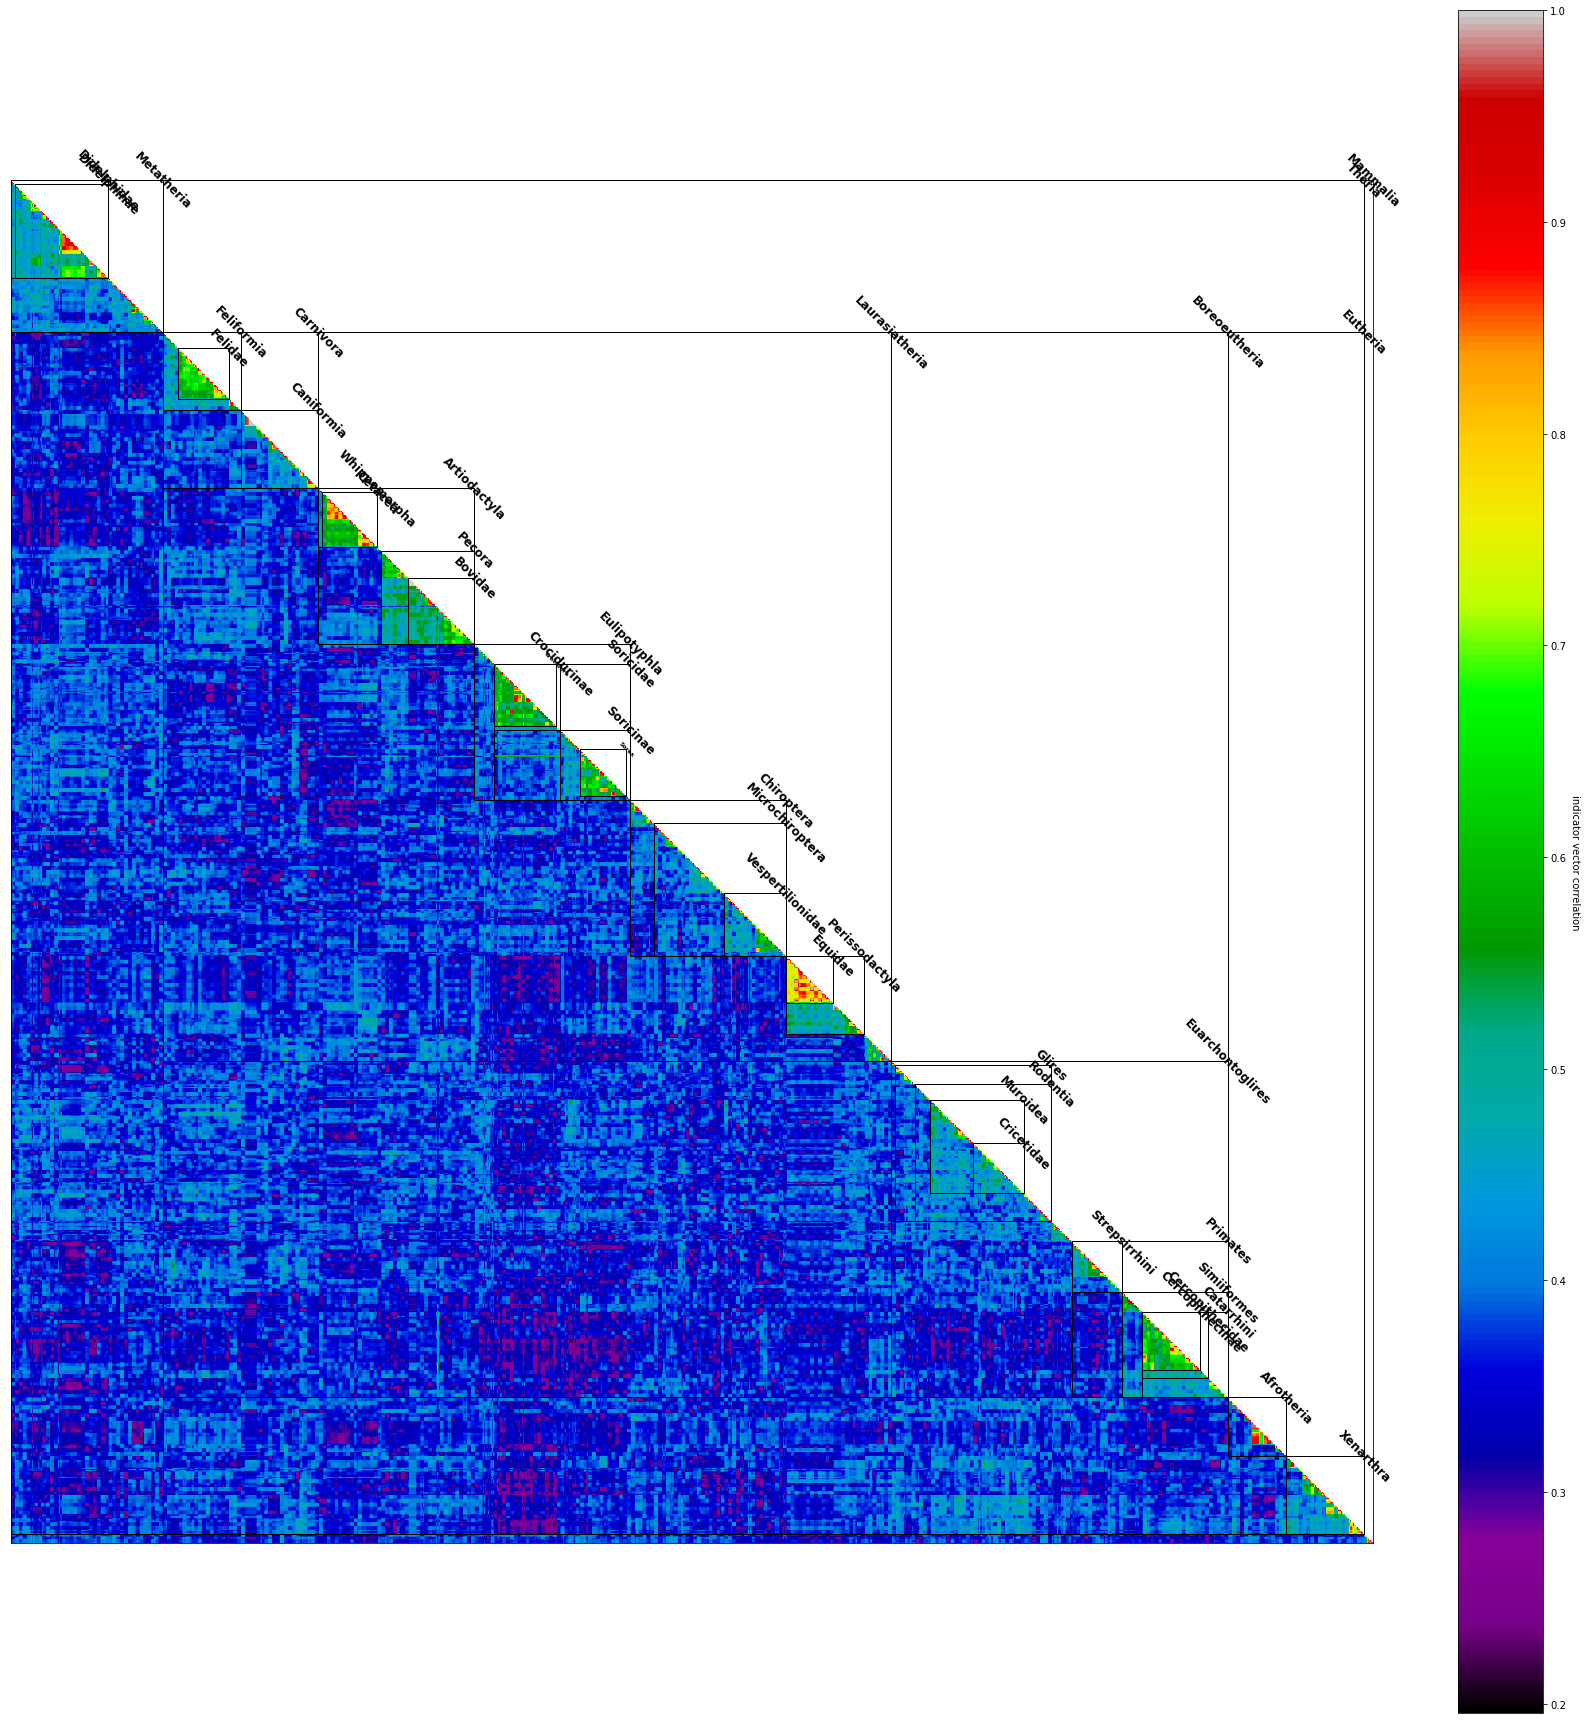

In [16]:
import matplotlib
fig,ax = plt.subplots(1,1 , figsize=(24,24))
colorMap = matplotlib.cm.get_cmap("nipy_spectral").copy()
colorMap.set_bad(color='white')
im, cbar = heatmap(doubleStMat , [] , [] , ax = ax,
       cmap=colorMap, cbarlabel="indicator vector correlation")

for n in phylaBrackets.keys():
    if n in taxaTree.splittingNodes  or n in taxaTree.genuses : # restricting to nodes that split
        
        if ( phylaBrackets[n][1] - phylaBrackets[n][0] ) < 30 :
            continue
        
        textArgs = {"fontsize":12,
                    "color":"black",
                    'weight':'bold',
                    'verticalalignment':"center",
                    'horizontalalignment':"center",
                    "rotation":-45
                    }
        if phylaRankDict.get(n) == "genus":
            textArgs['fontsize']=6

        makeBracketBox( im , phylaBrackets[n] , 
                       bracketLabel = phylaNameDict[ n ] , 
                       boxArgs={ "color":"black", "linewidth":1 } , textArgs = textArgs )

fig.tight_layout()
